In [2]:
import transformers
import torch
from huggingface_hub import notebook_login
import os
from openai import AzureOpenAI
import ast 
from tqdm import tqdm 
import numpy as np
import json
import ot
import qwikidata
from qwikidata.entity import WikidataItem
from qwikidata.linked_data_interface import get_entity_dict_from_api
import sys
sys.path.append('../') 
from SAKE.distributions import *
from SAKE.threshold import *
from SAKE.edit import *
notebook_login()

In [3]:
if torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'Using device: {device}')

Using device: mps


### load dataset

In [4]:
# with open('../data/ripple/popular.json') as f:
#     pop = json.load(f)

with open('../data/ripple/example.json') as f:
    pop = json.load(f)

indexes = (0,10)

### generate sentences

In [4]:
pop = generate_paraphrases_popular(pop=pop, provider="anthropic", api_key="your_api_key", model="claude-3-5-sonnet-latest", indexes=indexes)

100%|██████████| 10/10 [03:23<00:00, 20.36s/it]


In [6]:
pop = generate_implications_popular(pop, provider="anthropic", api_key="your_api_key", model="claude-3-5-sonnet-latest", indexes=indexes)

100%|██████████| 10/10 [01:17<00:00,  7.72s/it]


In [8]:
pop[0]['comp_list'][0:5]

['The capital of the country of citizenship of Leonardo DiCaprio is',
 'The currency of the country of citizenship of Leonardo DiCaprio is',
 'The president of the country of citizenship of Leonardo DiCaprio is',
 'The national anthem of the country of citizenship of Leonardo DiCaprio is',
 'The dominant language of the country of citizenship of Leonardo DiCaprio is']

In [4]:
# save cf (optional)
with open('../data/ripple/example.json', 'w') as f:
    json.dump(pop, f)

### load model

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_name = 'gpt2-xl'
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states = True).to('mps')
tokenizer = AutoTokenizer.from_pretrained(model_name)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


### extract representations

In [4]:
pop = extract_representations_popular(model=model, tokenizer=tokenizer, pop=pop, indexes=indexes, device='mps')

100%|██████████| 10/10 [08:19<00:00, 49.95s/it]


### save the dataset

In [5]:
with open('../data/ripple/example.json', 'w') as f:
    json.dump(pop, f)

### compute means

In [10]:
source_mean_embs = []
target_mean_embs = []
for i in range(indexes[0], indexes[1]):
    source_mean_embs.append(np.mean(np.concatenate([pop[i]['source_embs'], pop[i]['forced_source_embs']], axis = 0), axis = 0).tolist())
    #source_mean_embs.append(np.mean(cf[i]['forced_source_embs'], axis = 0).tolist())
    target_mean_embs.append(np.mean(pop[i]['target_embs'], axis = 0).tolist())

In [11]:
mean_diffs = []
for i in range(indexes[0], indexes[1]):
    mean_diffs.append(np.array(target_mean_embs[i]) - np.array(source_mean_embs[i]))

mean_diffs = [x.tolist() for x in mean_diffs]

### comp embeddings

In [12]:
# keep 10 highest correlated embeddings
for i in tqdm(range(indexes[0], indexes[1])):
    comp_diffs = []
    for h in range(len(pop[i]['source_comp_embs'])):
        comp_diffs.append(np.array(pop[i]['target_comp_embs'][h]) - np.array(pop[i]['source_comp_embs'][h]))

    comp_diffs = [x.tolist() for x in comp_diffs]
    # sorted_idx = sorted(range(len(comp_diffs)), key=lambda x: cosine_similarity(comp_diffs[x], mean_diffs[i]), reverse=True)
    top_10_idx = sorted(range(len(comp_diffs)), key=lambda x: cosine_similarity(comp_diffs[x], mean_diffs[i]), reverse=True)[:10]
    top_10_source_embs = [pop[i]['source_comp_embs'][x] for x in top_10_idx]
    top_10_target_embs = [pop[i]['target_comp_embs'][x] for x in top_10_idx]
    pop[i]['source_comp_embs'] = top_10_source_embs
    pop[i]['target_comp_embs'] = top_10_target_embs

100%|██████████| 10/10 [00:00<00:00, 158.60it/s]


In [13]:
# target comp
for i in range(indexes[0], indexes[1]):
    for h in range(len(pop[i]['target_comp_embs'])):
        # for each target embedding, generate another one by adding small normal noise
        target_last_h = pop[i]['target_comp_embs'][h]
        for n in range(4):
            rand = np.random.normal(0, 0.1, len(target_last_h))
            pop[i]['target_comp_embs'].append(list(target_last_h + rand))

In [14]:
# source comp
for i in range(indexes[0], indexes[1]):
    for h in range(len(pop[i]['source_comp_embs'])):
        # for each target embedding, generate another one by adding small normal noise
        target_last_h = pop[i]['source_comp_embs'][h]
        for n in range(4):
            rand = np.random.normal(0, 0.1, len(target_last_h))
            pop[i]['source_comp_embs'].append(list(target_last_h + rand))

### compute prompt embeddings

In [17]:
from sentence_transformers import SentenceTransformer
emb_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
prompt_embs = compute_prompt_means_popular(pop, emb_model, indexes=indexes)

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


### learn mappings

In [15]:
maps = []
for i in tqdm(range(indexes[0], indexes[1])):
    e = pop[i]
    x = np.concatenate([e['forced_source_embs'], e['source_embs'], e['source_comp_embs'], e['target_embs'], e['target_comp_embs']])
    #x = np.concatenate([e['forced_source_embs'], e['source_embs'], e['target_embs'], e['target_embs']])
    x_source = x[:2*len(e['forced_source_embs'])+len(e['source_comp_embs'])]
    x_target = x[2*len(e['forced_source_embs'])+len(e['source_comp_embs']):]
    ot_linear = ot.da.LinearTransport(reg=1e-2)
    ot_linear.fit(Xs=x_source, Xt=x_target)
    maps.append(ot_linear)

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


### Accuracy test

In [18]:
argmax_success = 0
total = 0
prob_indexes = []
for n in tqdm(range(indexes[0], indexes[1])):
    total += 1
    target_new_id = pop[n]['edit']['target_id']
    target_true_id = pop[n]['edit']['original_fact']['target_id']
    target_new = WikidataItem(get_entity_dict_from_api(target_new_id)).get_label()
    target_true = WikidataItem(get_entity_dict_from_api(target_true_id)).get_label()
    prompt = pop[n]['edit']['prompt'][:-len(target_new)-2]
    prompt_enc = emb_model.encode(prompt)
    input_ids = tokenizer(prompt, return_tensors="pt").to(device).input_ids 
       
    with torch.no_grad():
        model.eval()
        output = model(input_ids)

    last_h = output.hidden_states[-1][:,-1:,:].view(-1).cpu()
    pre_sim, max_index = prompt_threshold(prompt_enc, [prompt_embs[n]], 5, dist_type = "euc")
    if max_index is not None:
        last_h = torch.tensor(maps[n].transform(Xs=last_h), dtype = torch.float32)

    logits = torch.matmul(last_h.view(-1), model.lm_head.weight.T.cpu())

    next_token_probs = torch.softmax(logits, dim=-1)

    new_object_token = target_new
    new_object_token_id = tokenizer.encode(new_object_token, add_special_tokens = False)[0]
    new_object_token_prob = next_token_probs[new_object_token_id]   
    old_object_token = target_true
    old_object_token_id = tokenizer.encode(old_object_token, add_special_tokens = False)[0]
    old_object_token_prob = next_token_probs[old_object_token_id]

    if new_object_token_prob > old_object_token_prob:
        prob_indexes.append(n)

    next_token_id = torch.argmax(next_token_probs, dim = -1)
    next_token = tokenizer.decode(next_token_id).strip()
    
    # check if next_token is at the beginning of the string of the new_objec_token
    if new_object_token.startswith(next_token) :
        argmax_success += 1

print("------------------------------------")
print("Argmax score: ", argmax_success, "out of", total)
    

100%|██████████| 10/10 [00:13<00:00,  1.40s/it]

------------------------------------
Argmax score:  8 out of 10


### comp1 test

In [19]:
compI_idxs = []
for n in tqdm(range(indexes[0], indexes[1])):
    idxs = []
    for j in range(len(pop[n]['Compositionality_I'])):
        cond_prompt = pop[n]['Compositionality_I'][j]['condition_queries'][0]['prompt']
        cond_input_ids = tokenizer(cond_prompt, return_tensors="pt").input_ids.to('mps')
        with torch.no_grad():
            model.eval()
            cond_output = model(cond_input_ids)
        cond_last_h = cond_output.hidden_states[-1][:,-1,:]
        cond_logits = torch.matmul(cond_last_h, model.lm_head.weight.T)
        cond_next_token_probs = torch.softmax(cond_logits, dim=-1)
        cond_new_object_token = pop[n]['Compositionality_I'][j]['condition_queries'][0]['answers'][0]['value']
        aliases = pop[n]['Compositionality_I'][j]['condition_queries'][0]['answers'][0]['aliases']
        cond_next_token = tokenizer.decode(torch.argmax(cond_next_token_probs, dim = -1)).strip()
        if any(s.startswith(cond_next_token) for s in [cond_new_object_token] + aliases) and cond_next_token != "":
            idxs.append(j)
    compI_idxs.append(idxs)

100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


In [21]:
cI_argmax_success = 0
count = 0
for n in tqdm(range(len(pop))):
    if n not in prob_indexes:
        continue
    if pop[n]['Compositionality_I']:
        for j in range(len(pop[n]['Compositionality_I'])):
            if j not in compI_idxs[n]:
                continue
            count += 1
            prompt = pop[n]['Compositionality_I'][j]['test_queries'][0]['prompt']
            print(prompt)
            prompt_enc = emb_model.encode(prompt) 
            input_ids = tokenizer(prompt, return_tensors="pt").to('mps').input_ids
            with torch.no_grad():
                model.eval()
                output = model(input_ids)

            last_h = output.hidden_states[-1][:,-1:,:].view(-1).cpu()
            pre_sim, max_index = prompt_threshold(prompt_enc, [prompt_embs[n]], 6, dist_type = "euc")
            if max_index is not None:
                last_h = torch.tensor(maps[n].transform(Xs=last_h), dtype = torch.float32)

            logits = torch.matmul(last_h.view(-1), model.lm_head.weight.T.cpu())

            next_token_probs = torch.softmax(logits, dim=-1)

            new_object_token = pop[n]['Compositionality_I'][j]['test_queries'][0]['answers'][0]['value']
            new_object_token_id = tokenizer.encode(new_object_token, add_special_tokens = False)[0]
            new_object_token_prob = next_token_probs[new_object_token_id]   
            aliases = pop[n]['Compositionality_I'][j]['test_queries'][0]['answers'][0]['aliases']
            next_token_id = torch.argmax(next_token_probs, dim = -1)
            next_token = tokenizer.decode(next_token_id).strip()
            print(next_token)
            
            # check if the string of new_objec_token or of any of the aliases begins with next_token
            if any(s.startswith(next_token) for s in [new_object_token] + aliases) and next_token != "":
                cI_argmax_success += 1
print("------------------------------------")
print("Total number of edits: ", count)
print("Argmax score: ", cI_argmax_success/count, "with", cI_argmax_success, "out of", count, "edits")
    

  0%|          | 0/885 [00:00<?, ?it/s]

The official language of the country of citizenship of Leonardo DiCaprio is
English
The name of the capital city of the country of citizenship of Leonardo DiCaprio is
Damascus
The name of the head of state of the country of citizenship of Leonardo DiCaprio is


100%|██████████| 885/885 [00:02<00:00, 327.69it/s]

Bashar
------------------------------------
Total number of edits:  3
Argmax score:  0.6666666666666666 with 2 out of 3 edits


### comp2 test

In [29]:
compII_idxs = []
for n in tqdm(range(len(pop))):
    idxs = []
    for j in range(len(pop[n]['Compositionality_II'])):
        cond_prompt = pop[n]['Compositionality_II'][j]['condition_queries'][0]['prompt']
        cond_input_ids = tokenizer(cond_prompt, return_tensors="pt").input_ids.to('mps')
        with torch.no_grad():
            model.eval()
            cond_output = model(cond_input_ids)
        cond_last_h = cond_output.hidden_states[-1][:,-1,:]
        cond_logits = torch.matmul(cond_last_h, model.lm_head.weight.T)
        cond_next_token_probs = torch.softmax(cond_logits, dim=-1)
        cond_new_object_token = pop[n]['Compositionality_II'][j]['condition_queries'][0]['answers'][0]['value']
        aliases = pop[n]['Compositionality_II'][j]['condition_queries'][0]['answers'][0]['aliases']
        cond_next_token = tokenizer.decode(torch.argmax(cond_next_token_probs, dim = -1)).strip()
        if any(s.startswith(cond_next_token) for s in [cond_new_object_token] + aliases) and cond_next_token != "":
            idxs.append(j)
    compII_idxs.append(idxs)

100%|██████████| 885/885 [00:41<00:00, 21.10it/s]


In [31]:
tot = 0
for i in range(len(compII_idxs)):
    tot += len(compII_idxs[i])

print(tot)

30


In [37]:
argmax_success = 0
prob_success = 0
magnitude = []
dist = []
cII = []
for t in np.arange(5, 5.25, 0.25):
    cII_argmax_success = 0
    count = 0
    for n in tqdm(range(len(pop))):
        if not pop[n]['Compositionality_II']:
            continue
        if n not in prob_indexes:
            continue
        for j in range(len(pop[n]['Compositionality_II'])):
            if j not in compII_idxs[n]:
                continue
            count += 1
            prompt = pop[n]['Compositionality_II'][j]['test_queries'][0]['prompt']
            prompt_enc = emb_model.encode(prompt)
            input_ids = tokenizer(prompt, return_tensors="pt").input_ids
            for i in range(1):  
                inputs = tokenizer(prompt, return_tensors="pt").to('mps')
                input_ids = inputs.input_ids
                with torch.no_grad():
                    model.eval()
                    output = model(input_ids)

                if i == 0:
                    alpha = 0
                    last_h = output.hidden_states[-1][:,-1:,:].view(-1).cpu()
                    dist.append(distance.euclidean(prompt_enc, prompt_embs[n]))
                    pre_sim, max_index = prompt_threshold(prompt_enc, [prompt_embs[n]], t, dist_type = "euc")
                    if max_index is not None:
                        last_h = torch.tensor(maps[n].transform(Xs=last_h), dtype = torch.float32)
 
                    logits = torch.matmul(last_h.view(-1), model.lm_head.weight.T.cpu())
                else:
                    last_h = output.hidden_states[-1][:,-1,:]
                    logits = torch.matmul(last_h, model.lm_head.weight.T)
                next_token_probs = torch.softmax(logits, dim=-1)

                new_object_token = pop[n]['Compositionality_II'][j]['test_queries'][0]['answers'][0]['value']
                new_object_token_id = tokenizer.encode(new_object_token, add_special_tokens = False)[0]
                new_object_token_prob = next_token_probs[new_object_token_id]   
                aliases = pop[n]['Compositionality_II'][j]['test_queries'][0]['answers'][0]['aliases']
                next_token_id = torch.argmax(next_token_probs, dim = -1)
                next_token = tokenizer.decode(next_token_id).strip()
                
                # check if next_token is at the beginning of the string of the new_objec_token or in any of the elements of aliases, which is a list of strings
                if any(s.startswith(next_token) for s in [new_object_token] + aliases) and next_token != "":
                    cII_argmax_success += 1
    print(cII_argmax_success / count)
    cII.append(cII_argmax_success / count)
print("------------------------------------")
print("Total number of edits: ", count)
print("Argmax score: ", cII_argmax_success)
    

100%|██████████| 885/885 [00:04<00:00, 190.71it/s]

0.3
------------------------------------
Total number of edits:  30
Argmax score:  9


In [33]:
9 / 28

0.32142857142857145

### rel spec test

In [49]:
rs_idxs = []
for n in tqdm(range(len(pop))):
    idxs = []
    for j in range(len(pop[n]['Relation_Specificity'])):
        cond_prompt = pop[n]['Relation_Specificity'][j]['condition_queries'][0]['prompt']
        cond_input_ids = tokenizer(cond_prompt, return_tensors="pt").input_ids.to('mps')
        with torch.no_grad():
            model.eval()
            cond_output = model(cond_input_ids)
        cond_last_h = cond_output.hidden_states[-1][:,-1,:]
        cond_logits = torch.matmul(cond_last_h, model.lm_head.weight.T)
        cond_next_token_probs = torch.softmax(cond_logits, dim=-1)
        cond_new_object_token = pop[n]['Relation_Specificity'][j]['condition_queries'][0]['answers'][0]['value']
        aliases = pop[n]['Relation_Specificity'][j]['condition_queries'][0]['answers'][0]['aliases']
        cond_next_token = tokenizer.decode(torch.argmax(cond_next_token_probs, dim = -1)).strip()
        #print(cond_next_token)
        if any(s.startswith(cond_next_token) for s in [cond_new_object_token] + aliases) and cond_next_token != "":
            idxs.append(j)
    rs_idxs.append(idxs)

100%|██████████| 885/885 [08:41<00:00,  1.70it/s]


In [50]:
bad = 0
magnitude = []
rs = []

for t in np.arange(5,5.25,0.25):
    count = 0
    rs_success = 0
    for n in tqdm(range(len(pop))):
        if n not in prob_indexes:
            continue
        for j in range(len(pop[n]['Relation_Specificity'])):
            if j not in rs_idxs[n]:
                continue
            count += 1
            prompt = pop[n]['Relation_Specificity'][j]['test_queries'][0]['prompt']
            prompt_enc = emb_model.encode(prompt)
            input_ids = tokenizer(prompt, return_tensors="pt").input_ids
            inputs = tokenizer(prompt, return_tensors="pt").to('mps')
            input_ids = inputs.input_ids
            with torch.no_grad():
                model.eval()
                output = model(input_ids)

            prompt_sim, prompt_idx = prompt_threshold(prompt_enc, [prompt_embs[n]], t, dist_type = "euc")
            #hid_sim, hid_idx = hid_threshold(last_h, source_mean_embs, 25)
            if prompt_idx is None: # and hid_idx is None:
                rs_success += 1

            else: 
                last_h = output.hidden_states[-1][:,-1:,:].view(-1).cpu()
                last_h = torch.tensor(maps[n].transform(Xs=last_h), dtype = torch.float32)
                logits = torch.matmul(last_h.view(-1), model.lm_head.weight.T.cpu())
            
                next_token_probs = torch.softmax(logits, dim=-1)

                new_object_token = pop[n]['Relation_Specificity'][j]['test_queries'][0]['answers'][0]['value']
                new_object_token_id = tokenizer.encode(new_object_token, add_special_tokens = False)[0]
                new_object_token_prob = next_token_probs[new_object_token_id]   
                aliases = pop[n]['Relation_Specificity'][j]['test_queries'][0]['answers'][0]['aliases']
                next_token_id = torch.argmax(next_token_probs, dim = -1)
                next_token = tokenizer.decode(next_token_id).strip()
                
                # check if next_token is at the beginning of the string of the new_objec_token or in any of the elements of aliases, which is a list of strings
                if any(s.startswith(next_token) for s in [new_object_token] + aliases) and next_token != "":
                    rs_success += 1
            
print("Total number of edits evaluated:", count)
print("Specificity score: ", rs_success)

100%|██████████| 885/885 [00:59<00:00, 14.84it/s]

Total number of edits evaluated: 438
Specificity score:  264


In [51]:
264/438

0.6027397260273972

### sa test

In [42]:
sa_idxs = []
for n in tqdm(range(len(pop))):
    idxs = []
    for j in range(len(pop[n]['Subject_Aliasing'])):
        cond_prompt = pop[n]['Subject_Aliasing'][j]['condition_queries'][0]['prompt']
        cond_input_ids = tokenizer(cond_prompt, return_tensors="pt").input_ids.to('mps')
        with torch.no_grad():
            model.eval()
            cond_output = model(cond_input_ids)
        cond_last_h = cond_output.hidden_states[-1][:,-1,:].view(-1).cpu()
        cond_last_h = torch.tensor(maps[n-150].transform(Xs=cond_last_h), dtype = torch.float32)
        cond_logits = torch.matmul(cond_last_h.view(-1), model.lm_head.weight.T.cpu())
        cond_next_token_probs = torch.softmax(cond_logits, dim=-1)
        cond_new_object_token = pop[n]['Subject_Aliasing'][j]['condition_queries'][0]['answers'][0]['value']
        aliases = pop[n]['Subject_Aliasing'][j]['condition_queries'][0]['answers'][0]['aliases']
        cond_next_token = tokenizer.decode(torch.argmax(cond_next_token_probs, dim = -1)).strip()
        if any(s.startswith(cond_next_token) for s in [cond_new_object_token] + aliases) and cond_next_token != "":
            idxs.append(j)
    sa_idxs.append(idxs)

 51%|█████     | 447/885 [02:48<02:45,  2.65it/s]


KeyboardInterrupt: 

In [43]:
argmax_success = 0
prob_success = 0
magnitude = []
dist = []
count = 0
sa = []
for t in np.arange(5,5.25,0.25):
    sa_argmax_success = 0
    count = 0
    for n in tqdm(range(len(pop))):
        if n not in prob_indexes:
            continue
        if not pop[n]['Subject_Aliasing']:
            continue
        for j in range(len(pop[n]['Subject_Aliasing'])):
            # if j not in sa_idxs[n]:
            #     continue
            count += 1
            prompt = pop[n]['Subject_Aliasing'][j]['test_queries'][0]['prompt']
            prompt_enc = emb_model.encode(prompt)
            input_ids = tokenizer(prompt, return_tensors="pt").input_ids
            for i in range(1):  
                inputs = tokenizer(prompt, return_tensors="pt").to('mps')
                input_ids = inputs.input_ids
                with torch.no_grad():
                    model.eval()
                    output = model(input_ids)

                if i == 0:
                    alpha = 0
                    last_h = output.hidden_states[-1][:,-1:,:].view(-1).cpu()
                    dist.append(distance.euclidean(prompt_enc, prompt_embs[n]))
                    pre_sim, max_index = prompt_threshold(prompt_enc, [prompt_embs[n]], t, dist_type = "euc")
                    if max_index is not None:
                        last_h = torch.tensor(maps[n].transform(Xs=last_h), dtype = torch.float32)

                    logits = torch.matmul(last_h.view(-1), model.lm_head.weight.T.cpu())
                else:
                    last_h = output.hidden_states[-1][:,-1,:]
                    logits = torch.matmul(last_h, model.lm_head.weight.T)
                next_token_probs = torch.softmax(logits, dim=-1)

                new_object_token = pop[n]['Subject_Aliasing'][j]['test_queries'][0]['answers'][0]['value']
                new_object_token_id = tokenizer.encode(new_object_token, add_special_tokens = False)[0]
                new_object_token_prob = next_token_probs[new_object_token_id]   
                aliases = pop[n]['Subject_Aliasing'][j]['test_queries'][0]['answers'][0]['aliases']
                next_token_id = torch.argmax(next_token_probs, dim = -1)
                next_token = tokenizer.decode(next_token_id).strip()
                
                # check if next_token is at the beginning of the string of the new_objec_token or in any of the elements of aliases, which is a list of strings
                if any(s.startswith(next_token) for s in [new_object_token] + aliases) and next_token != "":
                    sa_argmax_success += 1
    print(sa_argmax_success, count)
    sa.append(sa_argmax_success / count)

100%|██████████| 885/885 [06:24<00:00,  2.30it/s]

1298 2307


argmax = 515/886, prob 864/886, cI = 73/146, cII = 86/432, rs = 188/322, sa = 1261/2310

In [ ]:
# results
# acc = [98.67]
# cI = [60, 63.33, 60, 66.67, 60]
# cII = [11.90, 14.28, 11.90, 16.67, 16.67]
# rs = [40, 40, 46.67, 53.33, 53.33]
# sa = [48.14, 47.62, 42.86, 40.21, 45.50]

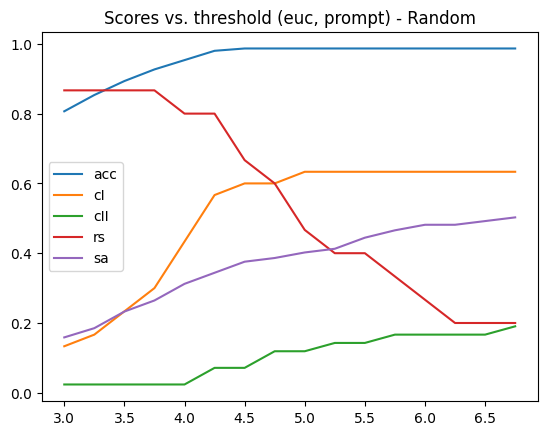

In [23]:
# plot prob successess, cI, cII, rs, sa
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(3,7,0.25)
fig, ax = plt.subplots()
prob_successes = [
    0.8066666666666666,0.8533333333333334,0.8933333333333333,0.9266666666666666,0.9533333333333334,0.98,0.9866666666666667,0.9866666666666667,0.9866666666666667,
0.9866666666666667,0.9866666666666667,0.9866666666666667,0.9866666666666667,0.9866666666666667,0.9866666666666667,0.9866666666666667
] # it's like this because I made a mistake before, it's not made up
ax.plot(x, prob_successes, label = 'acc')
ax.plot(x, cI, label = 'cI')
ax.plot(x, cII, label = 'cII')
ax.plot(x, rs, label = 'rs')
ax.plot(x, sa, label = 'sa')
ax.legend()
# add title
plt.title("Scores vs. threshold (euc, prompt) - Random")
plt.show()


In [98]:
prob_successes

[0.98]